In [1]:
%pip install torch torchvision torchaudio torchsummary 

Note: you may need to restart the kernel to use updated packages.


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import boto3
from io import BytesIO
from PIL import Image
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader

Noise Vector Shape: torch.Size([100])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 5000]         505,000
         LeakyReLU-2                 [-1, 5000]               0
         Unflatten-3            [-1, 8, 25, 25]               0
   ConvTranspose2d-4            [-1, 4, 50, 50]             516
       BatchNorm2d-5            [-1, 4, 50, 50]               8
         LeakyReLU-6            [-1, 4, 50, 50]               0
   ConvTranspose2d-7          [-1, 2, 100, 100]             130
       BatchNorm2d-8          [-1, 2, 100, 100]               4
         LeakyReLU-9          [-1, 2, 100, 100]               0
  ConvTranspose2d-10          [-1, 1, 200, 200]              33
             Tanh-11          [-1, 1, 200, 200]               0
Total params: 505,691
Trainable params: 505,691
Non-trainable params: 0
---------------------------------------------------------

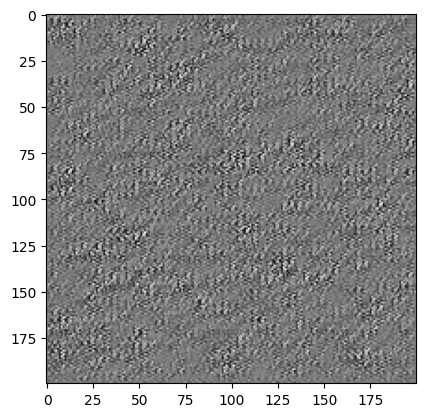

In [3]:
# generate output with dimension (1, 200, 200)

class Generator(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.latent_dim = latent_dim
        self.layers = nn.Sequential(
            
            nn.Linear(in_features=self.latent_dim, out_features=8*625),
            nn.LeakyReLU(negative_slope=0.2),

            nn.Unflatten(dim=-1, unflattened_size=(8, 25, 25)),
            nn.ConvTranspose2d(in_channels=8, out_channels=4, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(num_features=4),
            nn.LeakyReLU(negative_slope=0.2),
            nn.ConvTranspose2d(in_channels=4, out_channels=2, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(num_features=2),
            nn.LeakyReLU(negative_slope=0.2),
            nn.ConvTranspose2d(in_channels=2, out_channels=1, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
            
        )
    
    def forward(self, latent_vector):
        output = self.layers(latent_vector)
        return output

latent_dimension = 100
chemocraft_generator = Generator(latent_dim=latent_dimension)

noise_vector = torch.randn(size=(latent_dimension,))
print(f"Noise Vector Shape: {noise_vector.shape}")

summary(chemocraft_generator, input_size=(noise_vector.shape))

batch_size = 4
test_noise_vector = torch.randn(size=(batch_size, latent_dimension))
print(f"Test Noise Vector Shape: {test_noise_vector.shape}")

g_output = chemocraft_generator.forward(latent_vector=test_noise_vector)
print(f"Output Shape: {g_output.shape}")
print(f"Test Image: ")
plt.imshow(g_output[0][0].detach().numpy(), cmap='gray')
plt.show()

In [4]:
# take in input of (1, 200, 200) and give probability (sigmoid)

input_shape = torch.tensor([1, 200, 200])

class Discriminator(nn.Module):
    def __init__(self, input_shape):
        super().__init__()
        self.layers = nn.Sequential(

            nn.Conv2d(in_channels=input_shape[0], out_channels=16, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Flatten(),
            nn.Linear(in_features=64*25*25, out_features=1),
            nn.Sigmoid()
            
        )

    def forward(self, input):
        output = self.layers(input)
        return output
    
chemocraft_discriminator = Discriminator(input_shape=input_shape)

summary(chemocraft_discriminator, input_size=(1, 200, 200))

test_fake_images = g_output
print(f"Input Shape: {test_fake_images.shape}")

d_output = chemocraft_discriminator.forward(test_fake_images)
print(f"Output Shape: {d_output.shape}")
print(f"Test Probability of Real: {d_output}")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 100, 100]             272
         LeakyReLU-2         [-1, 16, 100, 100]               0
            Conv2d-3           [-1, 32, 50, 50]           8,224
         LeakyReLU-4           [-1, 32, 50, 50]               0
            Conv2d-5           [-1, 64, 25, 25]          32,832
         LeakyReLU-6           [-1, 64, 25, 25]               0
           Flatten-7                [-1, 40000]               0
            Linear-8                    [-1, 1]          40,001
           Sigmoid-9                    [-1, 1]               0
Total params: 81,329
Trainable params: 81,329
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.15
Forward/backward pass size (MB): 4.58
Params size (MB): 0.31
Estimated Total Size (MB): 5.04
---------------------------------------------

There are 20196 images. ('.png' files)
torch.Size([1, 200, 200])


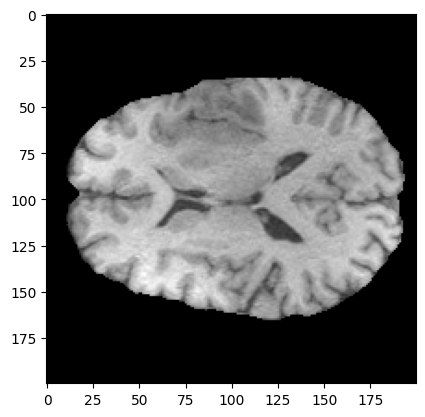

tanmay/brain_slices/002/t1/76.png


In [5]:
s3 = boto3.resource('s3')
bucket_name = 'chemocraft-data'
folder_path = 'tanmay/brain_slices/'

class S3ImageDataset(Dataset):
    def __init__(self, s3_bucket_name, folder, transforms):
        self.s3_bucket_name = s3_bucket_name
        self.folder = folder
        self.bucket = s3.Bucket(self.s3_bucket_name)
        self.brain_ids = []
        self.slice_keys = []
        self.transforms = transforms

    def brain_ids_list(self):
        
        for obj in self.bucket.objects.filter(Prefix=self.folder):
            if obj.key.endswith('.png'):
                brain_id = obj.key.split('/')[-3] # getting the brain IDs
                if brain_id not in self.brain_ids:
                    self.brain_ids.append(brain_id)
        
        return self.brain_ids
    
    def sort_order(self, filepath): # returns sort order for the sort() function
        file_parts = filepath.split('/')
        brain_id = file_parts[-3] #002
        scan_type = file_parts[-2] # t1ce
        slice_idx = file_parts[-1] # 55.png

        slice_number = int(slice_idx.split('.')[0])

        return (brain_id, scan_type, slice_number)

    def __get_s3_keys__(self):
        
        for obj in self.bucket.objects.filter(Prefix=f"{self.folder}"):
            for num in range(50, 101):
                if obj.key.endswith('.png') and ('seg') not in obj.key and (f'/{num}.') in obj.key:
                    self.slice_keys.append(obj.key)
        
        self.slice_keys = sorted(self.slice_keys, key = self.sort_order)

        return self.slice_keys
    
    def __len__(self):
        return len(self.slice_keys)
    
    def __getitem__(self, idx):
        
        s3_key = self.slice_keys[idx]
        s3_image = self.bucket.Object(s3_key).get()
        img_data = s3_image['Body'].read()

        image = Image.open(BytesIO(img_data)).convert('L')

        transformed_image = self.transforms(image)
        
        return transformed_image
        

mri_transforms = transforms.Compose([
    transforms.Resize((200, 200)),
    transforms.ToTensor(),
    transforms.Grayscale(num_output_channels=1),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

S3Images = S3ImageDataset(s3_bucket_name=bucket_name, folder=folder_path, transforms=mri_transforms)

keys = S3Images.brain_ids_list()
image_keys = S3Images.__get_s3_keys__()
num_images = S3Images.__len__()
image = S3Images.__getitem__(77)

print(f"There are {num_images} images. ('.png' files)")
print(image.shape)
plt.imshow(image.squeeze(), cmap='gray')
plt.show()
print(image_keys[77])

In [6]:
print(image_keys)

['tanmay/brain_slices/002/flair/50.png', 'tanmay/brain_slices/002/flair/51.png', 'tanmay/brain_slices/002/flair/52.png', 'tanmay/brain_slices/002/flair/53.png', 'tanmay/brain_slices/002/flair/54.png', 'tanmay/brain_slices/002/flair/55.png', 'tanmay/brain_slices/002/flair/56.png', 'tanmay/brain_slices/002/flair/57.png', 'tanmay/brain_slices/002/flair/58.png', 'tanmay/brain_slices/002/flair/59.png', 'tanmay/brain_slices/002/flair/60.png', 'tanmay/brain_slices/002/flair/61.png', 'tanmay/brain_slices/002/flair/62.png', 'tanmay/brain_slices/002/flair/63.png', 'tanmay/brain_slices/002/flair/64.png', 'tanmay/brain_slices/002/flair/65.png', 'tanmay/brain_slices/002/flair/66.png', 'tanmay/brain_slices/002/flair/67.png', 'tanmay/brain_slices/002/flair/68.png', 'tanmay/brain_slices/002/flair/69.png', 'tanmay/brain_slices/002/flair/70.png', 'tanmay/brain_slices/002/flair/71.png', 'tanmay/brain_slices/002/flair/72.png', 'tanmay/brain_slices/002/flair/73.png', 'tanmay/brain_slices/002/flair/74.png',

In [7]:
mri_dataloader = DataLoader(dataset=S3Images, batch_size=18, shuffle=True)

lr = 2e-4
beta1 = 0.5

optimizer_G = optim.Adam(chemocraft_generator.parameters(), lr=lr, betas=(beta1, 0.999))
optimizer_D = optim.Adam(chemocraft_discriminator.parameters(), lr=lr, betas=(beta1, 0.999))

criterion = nn.BCELoss()

d_losses = []
g_losses = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator_on_device = chemocraft_generator.to(device)
discriminator_on_device = chemocraft_discriminator.to(device)

print(generator_on_device, discriminator_on_device)

Generator(
  (layers): Sequential(
    (0): Linear(in_features=100, out_features=5000, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Unflatten(dim=-1, unflattened_size=(8, 25, 25))
    (3): ConvTranspose2d(8, 4, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): ConvTranspose2d(4, 2, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2)
    (9): ConvTranspose2d(2, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (10): Tanh()
  )
) Discriminator(
  (layers): Sequential(
    (0): Conv2d(1, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): LeakyReLU(negative_slope=0.2)
    (4): Conv2d(3

Epoch: [1/5]
Epoch: [1/5], Batch: [187/1122], G Loss: [3.7661], D Loss: [0.1974]


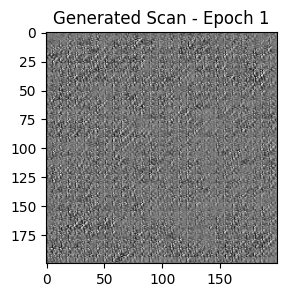

Epoch: [1/5], Batch: [374/1122], G Loss: [3.2015], D Loss: [0.3049]


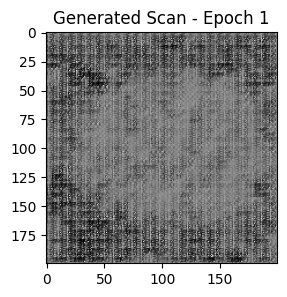

Epoch: [1/5], Batch: [561/1122], G Loss: [3.7330], D Loss: [0.2178]


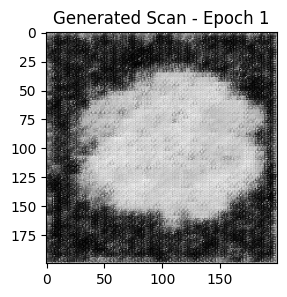

Epoch: [1/5], Batch: [748/1122], G Loss: [2.8014], D Loss: [0.3660]


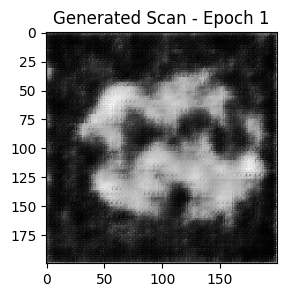

Epoch: [1/5], Batch: [935/1122], G Loss: [2.7844], D Loss: [0.2437]


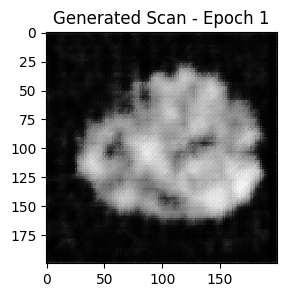

Epoch: [1/5], Batch: [1122/1122], G Loss: [1.7919], D Loss: [0.4519]


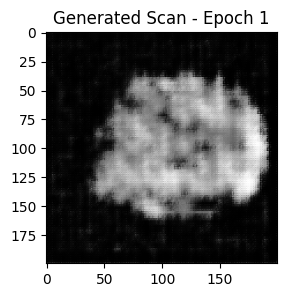

Epoch: [2/5]
Epoch: [2/5], Batch: [187/1122], G Loss: [2.6839], D Loss: [0.2773]


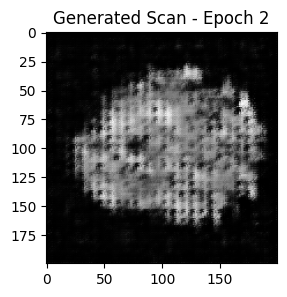

Epoch: [2/5], Batch: [374/1122], G Loss: [2.7227], D Loss: [0.6034]


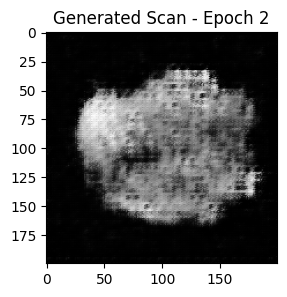

Epoch: [2/5], Batch: [561/1122], G Loss: [1.9070], D Loss: [0.5193]


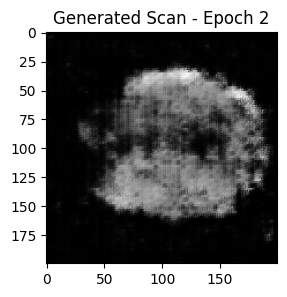

Epoch: [2/5], Batch: [748/1122], G Loss: [1.7753], D Loss: [0.5004]


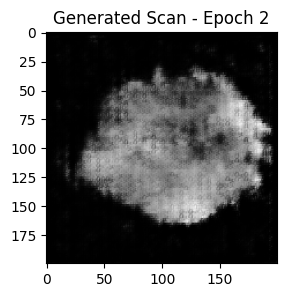

Epoch: [2/5], Batch: [935/1122], G Loss: [0.9979], D Loss: [0.5689]


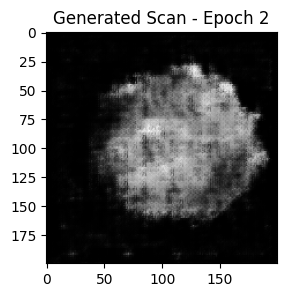

Epoch: [2/5], Batch: [1122/1122], G Loss: [0.8394], D Loss: [0.5976]


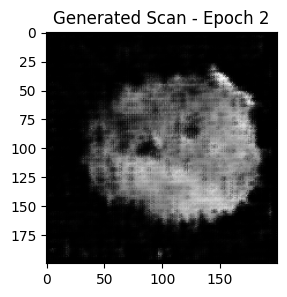

Epoch: [3/5]
Epoch: [3/5], Batch: [187/1122], G Loss: [1.4979], D Loss: [0.4513]


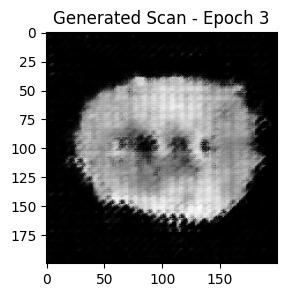

Epoch: [3/5], Batch: [374/1122], G Loss: [3.4122], D Loss: [0.6006]


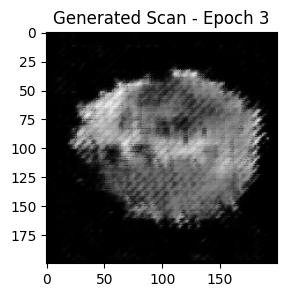

Epoch: [3/5], Batch: [561/1122], G Loss: [2.3317], D Loss: [0.4185]


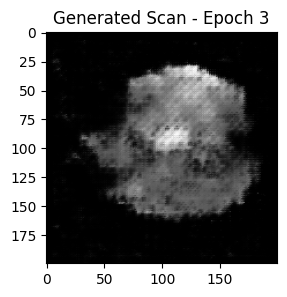

Epoch: [3/5], Batch: [748/1122], G Loss: [3.6177], D Loss: [0.4455]


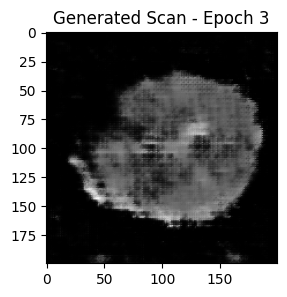

Epoch: [3/5], Batch: [935/1122], G Loss: [3.1604], D Loss: [0.3260]


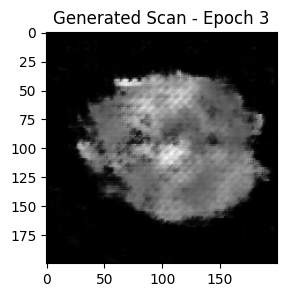

Epoch: [3/5], Batch: [1122/1122], G Loss: [2.8390], D Loss: [0.8055]


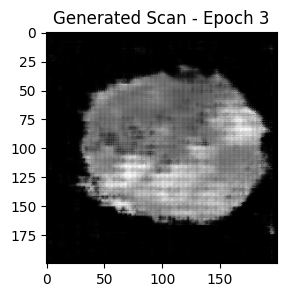

Epoch: [4/5]
Epoch: [4/5], Batch: [187/1122], G Loss: [1.5901], D Loss: [0.5393]


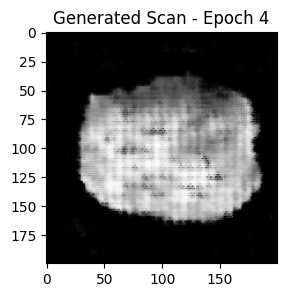

Epoch: [4/5], Batch: [374/1122], G Loss: [1.8582], D Loss: [0.4680]


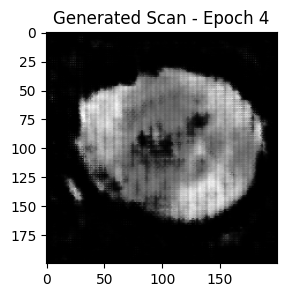

Epoch: [4/5], Batch: [561/1122], G Loss: [1.9054], D Loss: [0.4254]


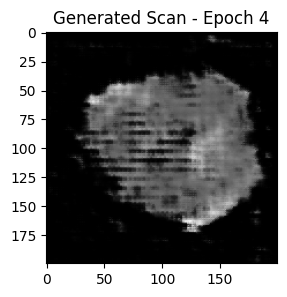

Epoch: [4/5], Batch: [748/1122], G Loss: [1.4934], D Loss: [0.4983]


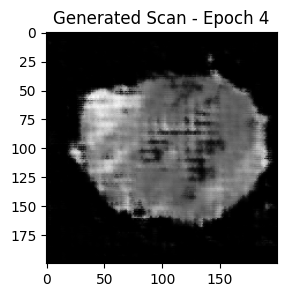

Epoch: [4/5], Batch: [935/1122], G Loss: [2.3438], D Loss: [0.6812]


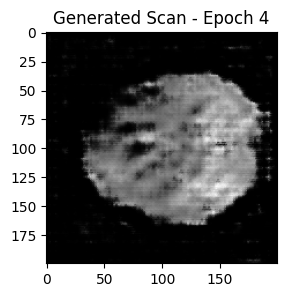

Epoch: [4/5], Batch: [1122/1122], G Loss: [2.3838], D Loss: [0.4640]


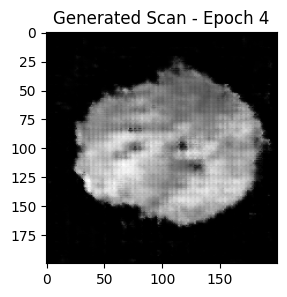

Epoch: [5/5]
Epoch: [5/5], Batch: [187/1122], G Loss: [2.2429], D Loss: [0.4721]


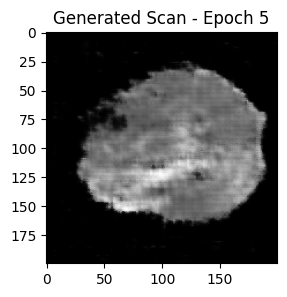

Epoch: [5/5], Batch: [374/1122], G Loss: [1.5117], D Loss: [0.6094]


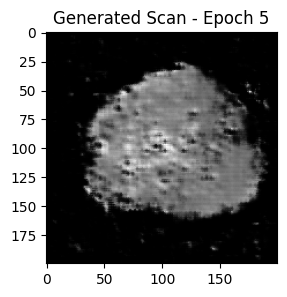

Epoch: [5/5], Batch: [561/1122], G Loss: [2.5935], D Loss: [0.5667]


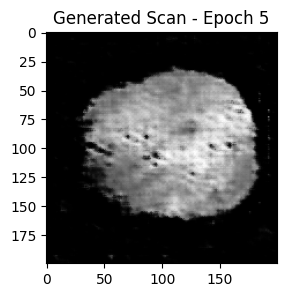

Epoch: [5/5], Batch: [748/1122], G Loss: [1.7731], D Loss: [0.4581]


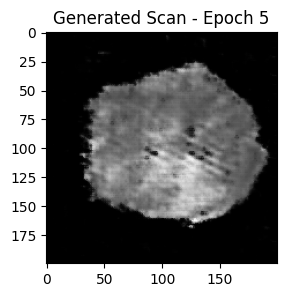

Epoch: [5/5], Batch: [935/1122], G Loss: [3.0443], D Loss: [0.4129]


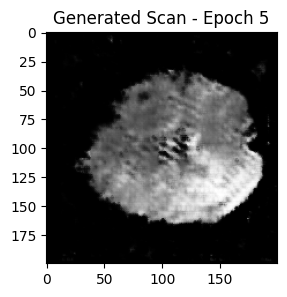

Epoch: [5/5], Batch: [1122/1122], G Loss: [1.3600], D Loss: [0.5563]


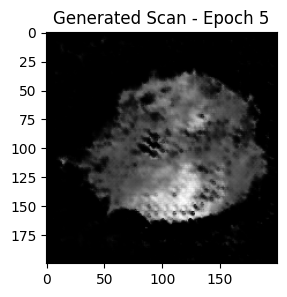

In [8]:
epochs = 5
real_label = 0.98
fake_label = 0.02

for epoch in range(epochs):
    print(f"Epoch: [{epoch+1}/{epochs}]")
    for i, data in enumerate(mri_dataloader, start=0):
        # Get the real images from the dataloader
        real_images = data.to(device)
        batch_size = real_images.size(0)
        labels_real = torch.full((batch_size, 1), real_label, device=device).float()
        labels_fake = torch.full((batch_size, 1), fake_label, device=device).float()

        optimizer_D.zero_grad()

        # Forward pass for real images
        output_real = discriminator_on_device(real_images)
        loss_real = criterion(output_real, labels_real)
        loss_real.backward()

        z = torch.randn(batch_size, latent_dimension, device=device)
        fake_images = generator_on_device(z)
        output_fake = discriminator_on_device(fake_images.detach())  # Don't compute gradients for fake images
        loss_fake = criterion(output_fake, labels_fake)
        loss_fake.backward()

        d_loss = (loss_real + loss_fake)
        optimizer_D.step()

        # Zero the gradients for the generator
        optimizer_G.zero_grad()

        # Forward pass for fake images
        output_fake = discriminator_on_device(fake_images) # no detach here since we are training generator and the gradient is important
        g_loss = criterion(output_fake, labels_real)  # We want the fake images to be classified as real

        # Backpropagate the generator loss
        g_loss.backward()
        optimizer_G.step()

        if (i+1) % 187 == 0: # dislpays 6 times/epoch
            print(f"Epoch: [{epoch+1}/{epochs}], Batch: [{i+1}/{len(mri_dataloader)}], G Loss: [{g_loss.item():.4f}], D Loss: [{d_loss.item():.4f}]")
            fake_images = fake_images.detach().cpu()
            plt.figure(figsize=(3,3))
            plt.imshow(fake_images[7][0], cmap='gray') # every 8th image from epoch will be displayed
            plt.title(f"Generated Scan - Epoch {epoch + 1}")
            plt.show()

    d_losses.append(d_loss.item())
    g_losses.append(g_loss.item())

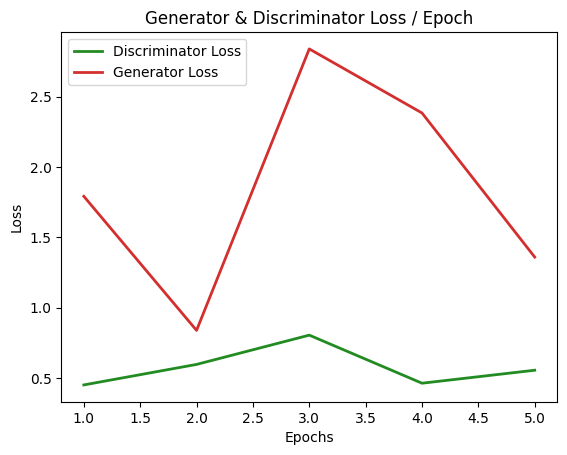

In [10]:
import matplotlib.pyplot as plt

epochs = range(1, 6)  # 5 epochs

# Creating a plot
plt.plot(epochs, d_losses, label='Discriminator Loss', color='#228B22', linewidth=2)
plt.plot(epochs, g_losses, label='Generator Loss', color='#D32F2F', linewidth=2)

# Labeling the axes and the title
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Generator & Discriminator Loss / Epoch')

# Show the legend
plt.legend()

# Display the plot
plt.show()

Test Noise Vector Shape: torch.Size([1, 100])
Output Shape: torch.Size([1, 1, 200, 200])
Test Image: 


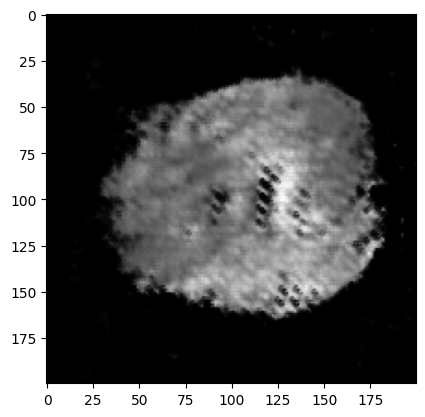

Test Noise Vector Shape: torch.Size([1, 100])
Output Shape: torch.Size([1, 1, 200, 200])
Test Image: 


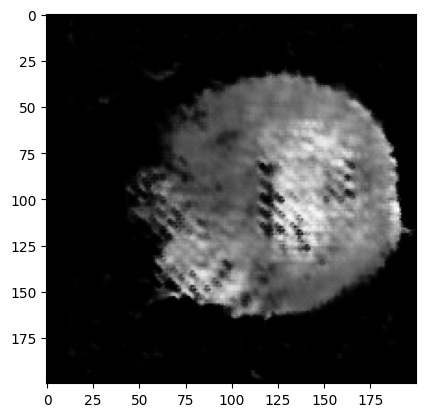

Test Noise Vector Shape: torch.Size([1, 100])
Output Shape: torch.Size([1, 1, 200, 200])
Test Image: 


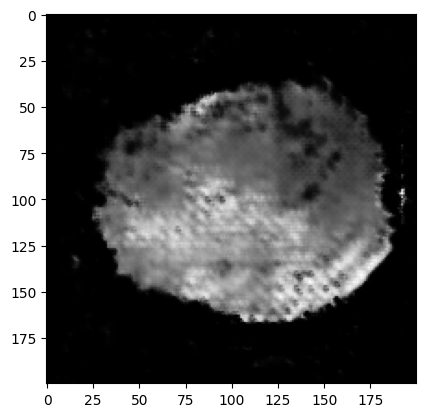

Test Noise Vector Shape: torch.Size([1, 100])
Output Shape: torch.Size([1, 1, 200, 200])
Test Image: 


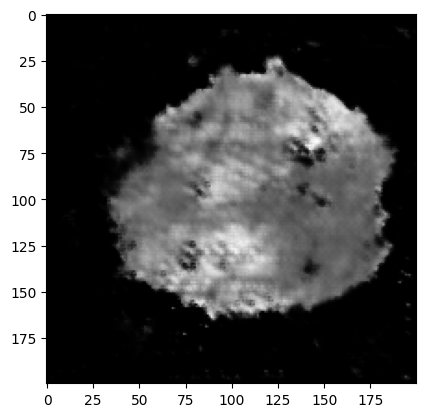

In [11]:
for i in range(4):
    test_noise_vector = torch.randn(size=(1, latent_dimension))
    print(f"Test Noise Vector Shape: {test_noise_vector.shape}")
    g_output = chemocraft_generator.forward(latent_vector=test_noise_vector)
    print(f"Output Shape: {g_output.shape}")
    print(f"Test Image: ")
    plt.imshow(g_output[0][0].detach().numpy(), cmap='gray')
    plt.show()